## Student-t Temperature Scaling

In [4]:
import os
import csv
import time
import math
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import defaultdict
from skorch import NeuralNetRegressor
from scipy.stats import t as student_t
from scipy.stats import ttest_rel, wilcoxon
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin


# === Synthetic Data Generation ===
def generate_sinusoidal_data(n_samples=1000):
    x = np.random.uniform(-3, 3, size=(n_samples, 1))
    y_clean = 2 * np.sin(3 * x + 4) + 5
    y_noisy = y_clean + 0.5 * np.random.randn(n_samples, 1)
    return x.astype(np.float32), y_noisy.astype(np.float32)

def generate_ishigami_1d_data(n_samples=1000, a=7.0, b=0.1, noise_level=0.5):
    x = np.random.uniform(-np.pi, np.pi, size=(n_samples, 1))
    y_clean = np.sin(x) + a * np.sin(x)**2 + b * x**4 * np.sin(x)
    noise = noise_level * (1 + np.abs(x)) * np.random.randn(n_samples, 1)
    y_noisy = y_clean + noise
    return x.astype(np.float32), y_noisy.astype(np.float32)

def generate_ishigami_3d_data(n_samples=1000, a=7.0, b=0.1, noise_level=0.5):
    x = np.random.uniform(-np.pi, np.pi, size=(n_samples, 3))
    x1, x2, x3 = x[:, 0], x[:, 1], x[:, 2]
    y_clean = np.sin(x1) + a * np.sin(x2)**2 + b * x3**4 * np.sin(x1)
    noise = noise_level * (1 + np.linalg.norm(x, axis=1)) * np.random.randn(n_samples)
    y_noisy = y_clean + noise
    return x.astype(np.float32), y_noisy.reshape(-1, 1).astype(np.float32)

# === UCI Data Generation ===
def load_uci_dataset(dataset_name):
    """Load a UCI dataset from local storage, preprocess it, and split into train/calibration/test sets."""
    dataset_paths = {
        "concrete": "./local_datasets/Concrete_Data.xls",
        "energy": "./local_datasets/ENB2012_data.xlsx",
        "wine-red": "./local_datasets/winequality-red.csv",
        "wine-white": "./local_datasets/winequality-white.csv",
        "yacht": "./local_datasets/yacht_hydrodynamics.data"
    }

    if dataset_name not in dataset_paths:
        raise ValueError(f"Dataset '{dataset_name}' not found in available datasets.")

    dataset_path = dataset_paths[dataset_name]
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset '{dataset_name}' not found locally. Please download it.")

    # Load the dataset
    if dataset_name == "concrete":
        df = pd.read_excel(dataset_path)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
    elif dataset_name == "energy":
        df = pd.read_excel(dataset_path)
        # Use only one target (e.g., "Heating Load")
        X = df.iloc[:, :-2].values  # Features
        y = df.iloc[:, -2].values   # Only "Heating Load" (change -2 to -1 for "Cooling Load")
    elif dataset_name in ["wine-red", "wine-white"]:
        df = pd.read_csv(dataset_path, sep=";")
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values
    elif dataset_name == "yacht":
        column_names = ["Longitudinal Position", "Prismatic Coefficient", "Length-Displacement Ratio",
                        "Beam-Draught Ratio", "Length-Beam Ratio", "Froude Number", "Resistance"]
        df = pd.read_csv(dataset_path, delim_whitespace=True, names=column_names)
        X = df.iloc[:, :-1].values
        y = df.iloc[:, -1].values

    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train/Calibration/Test split (70%-15%-15%)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Return the split data as NumPy arrays (to match synthetic datasets)
    return (
        X_train.astype(np.float32), y_train.astype(np.float32),
        X_calib.astype(np.float32), y_calib.astype(np.float32),
        X_test.astype(np.float32), y_test.astype(np.float32)
    )

# === Data Helper Function ===
def generate_dataset(dataset_type, n_samples=1000):
    if dataset_type == "sinusoidal":
        return generate_sinusoidal_data(n_samples)
    elif dataset_type == "ishigami_1d":
        return generate_ishigami_1d_data(n_samples)
    elif dataset_type == "ishigami_3d":
        return generate_ishigami_3d_data(n_samples)
    elif dataset_type in ["concrete", "energy", "wine-red", "wine-white", "yacht"]:
        return load_uci_dataset(dataset_type)
    else:
        raise ValueError(f"Unknown dataset_type: {dataset_type}")


# === Metric Comparisons and Plot Generation ===
def run_significance_tests_multiple(metrics):
    for metric_name, metric_dict in metrics.items():
        print(f"\n--- {metric_name} ---")
        strategies = list(metric_dict.keys())
        for i in range(len(strategies)):
            for j in range(i + 1, len(strategies)):
                s1, s2 = strategies[i], strategies[j]
                vals1, vals2 = np.array(metric_dict[s1]), np.array(metric_dict[s2])

                mask = ~np.isnan(vals1) & ~np.isnan(vals2)
                if len(vals1[mask]) < 2:
                    continue

                t_stat, p_val_t = ttest_rel(vals1[mask], vals2[mask])
                try:
                    w_stat, p_val_w = wilcoxon(vals1[mask], vals2[mask])
                    print(f"  {s1} → {s2}: t = {t_stat:.3f}, p_t = {p_val_t:.3g} | W = {w_stat:.3f}, p_w = {p_val_w:.3g}")
                except ValueError:
                    print(f"  {s1} → {s2}: t = {t_stat:.3f}, p_t = {p_val_t:.3g} | Wilcoxon failed")

def print_all_percent_change_summaries(metric_data, label=""):
    print(f"\n=== Percent Change Summary: {label} ===")
    strategies = list(next(iter(metric_data.values())).keys())

    def pct_change(before, after):
        return 100 * (after - before) / before if before != 0 else 0

    for metric_name, strategy_dict in metric_data.items():
        print(f"\n--- {metric_name} ---")
        for i in range(len(strategies)):
            for j in range(i + 1, len(strategies)):
                s1, s2 = strategies[i], strategies[j]
                v1 = np.mean(strategy_dict[s1])
                v2 = np.mean(strategy_dict[s2])
                print(f"{s1:20} → {s2:20}: {v1:.4f} → {v2:.4f} ({pct_change(v1, v2):+.2f}%)")

    # === Run statistical tests ===
    run_significance_tests_multiple(metric_data)
        
def plot_with_seaborn_all_strategies(
    metric_data_dict,
    title_prefix,
    ylabel,
    name,
    alpha_,
    data,
    nu_dict=None,
    output_dir=".",
):

    def bootstrap_ci(data, n_bootstrap=1000, ci=95):
        boot_means = np.random.choice(data, (n_bootstrap, len(data)), replace=True).mean(axis=1)
        lower = np.percentile(boot_means, (100 - ci) / 2)
        upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
        return lower, upper

    metric_names = list(metric_data_dict.keys())
    strategies = list(next(iter(metric_data_dict.values())).keys())
    num_metrics = len(metric_names)
    include_nu_plot = nu_dict is not None

    cols = 3
    rows = int(np.ceil((num_metrics + (1 if include_nu_plot else 0)) / cols))
    fig, axs = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axs = axs.flatten()

    color_palette = sns.color_palette("husl", len(strategies))
    label_map = {
        "studentT(unscaled)": "Student-t (learned ν)",
        "studentT(posthoc_nu)": "Student-t (posthoc ν)"
    }

    for i, metric_name in enumerate(metric_names):
        ax = axs[i]
        for strat, color in zip(strategies, color_palette):
            values = metric_data_dict[metric_name].get(strat, [])
            if len(values) == 0:
                continue
            sns.histplot(values, bins=10, kde=True, color=color, label=label_map.get(strat, strat),
                         ax=ax, stat="density", element="step")
            mean_val = np.mean(values)
            ci_low, ci_high = bootstrap_ci(values)
            ax.axvline(mean_val, linestyle="--", color=color,
                       label=f"{label_map.get(strat, strat)} μ={mean_val:.3f} CI=[{ci_low:.3f}, {ci_high:.3f}]")

        ax.set_title(f"{title_prefix} | {metric_name}")
        ax.set_xlabel(metric_name)
        ax.set_ylabel(ylabel)
        ax.legend()

    # Plot ν distributions if provided
    if include_nu_plot:
        ax_nu = axs[num_metrics]
        for strat, color in zip(strategies, color_palette):
            if strat not in nu_dict:
                continue
            values = nu_dict[strat]
            mean_nu = np.mean(values)
            sns.histplot(values, bins=10, kde=True, color=color,
                         label=f"{label_map.get(strat, strat)} (ν̄ = {mean_nu:.2f})",
                         ax=ax_nu, stat="density", element="step")
            ax_nu.axvline(mean_nu, linestyle="--", color=color)
        ax_nu.set_title(f"{title_prefix} | Learned ν Distribution")
        ax_nu.set_xlabel("Degrees of Freedom (ν)")
        ax_nu.set_ylabel("Density")
        ax_nu.legend()

    for j in range(num_metrics + (1 if include_nu_plot else 0), len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.suptitle(f"Histogram Metrics — {data} | α = {alpha_} | {name}", fontsize=16)

    safe_name = name.replace("+", "plus").replace("-", "minmax").replace(" ", "_").lower()
    filename = f"{data}_alpha{alpha_}_{safe_name}_histograms.png"
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(os.path.join(output_dir, filename), dpi=300)
    plt.show()
    
def log_metrics_to_csv(csv_path, dataset, alpha, trial, strategy,
                       coverage, width, mae, loss, mean_nu=None, all_nus=None):
    # Prepare scalar log row
    nu_val = round(mean_nu, 6) if isinstance(mean_nu, (int, float)) else "NA"

    log_row = {
        "Dataset": dataset,
        "Alpha": alpha,
        "Trial": trial,
        "Strategy": strategy,
        "Coverage": coverage,
        "Width": width,
        "MAE": mae,
        "Loss": loss,
        "Miscoverage": 1 - coverage,
        "CalibrationError": abs(coverage - (1 - alpha)),
        "MeanNu": nu_val
    }

    # Log summary row (as usual)
    pd.DataFrame([log_row]).to_csv(
        csv_path, mode="a", header=not os.path.exists(csv_path), index=False
    )

    # Log per-sample nu values only for unscaled studentT model
    if strategy == "studentT(unscaled)" and all_nus is not None:
        nu_detail_path = csv_path.replace(".csv", "_nu_details.csv")
        nu_rows = [{
            "Dataset": dataset,
            "Alpha": alpha,
            "Trial": trial,
            "Strategy": strategy,
            "Index": i,
            "Nu": float(nu_val)
        } for i, nu_val in enumerate(all_nus)]

        pd.DataFrame(nu_rows).to_csv(
            nu_detail_path, mode="a", header=not os.path.exists(nu_detail_path), index=False
        )
        
def print_average_metrics_per_dataset_alpha_strategy(csv_file):
    df = pd.read_csv(csv_file)

    grouped = df.groupby(["Dataset", "Alpha", "Strategy"])

    metrics = ["Coverage", "Width", "MAE", "Miscoverage", "CalibrationError"]

    print("\n=== Average Metrics per Dataset, Alpha, and Strategy ===")
    for (dataset, alpha), group_df in df.groupby(["Dataset", "Alpha"]):
        print(f"\n--- Dataset: {dataset}, Alpha: {alpha} ---")
        for strategy in sorted(group_df["Strategy"].unique()):
            strat_df = group_df[group_df["Strategy"] == strategy]
            print(f"  Strategy: {strategy}")
            for metric in metrics:
                if metric in strat_df.columns:
                    avg = strat_df[metric].mean()
                    std = strat_df[metric].std()
                    print(f"    {metric}: {avg:.4f} ± {std:.4f}")

def evaluate_predictions(y_true, y_pred, alpha=0.05, var=None, nu=None):
    """Compute coverage, width, and MAE given predictions and ground truth."""
    mae = mean_absolute_error(y_true, y_pred)
    if var is not None and nu is None:
        # Gaussian interval
        z = student_t.ppf(1 - alpha / 2, df=1000)  # Approximate Gaussian
        lower = y_pred - z * np.sqrt(var)
        upper = y_pred + z * np.sqrt(var)
    elif var is not None and nu is not None:
        # Student-t interval
        z = student_t.ppf(1 - alpha / 2, df=nu)
        lower = y_pred - z * np.sqrt(var)
        upper = y_pred + z * np.sqrt(var)
    else:
        raise ValueError("Must provide var (and optionally nu)")

    coverage = ((y_true >= lower) & (y_true <= upper)).mean()
    width = (upper - lower).mean()
    return coverage, width, mae

                    
# === PNN Model ===
class StudentTPNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, fixed_nu=None):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.mean = nn.Linear(hidden_dim, 1)
        self.log_var = nn.Linear(hidden_dim, 1)
        self.log_nu = nn.Linear(hidden_dim, 1)
        self.fixed_nu = fixed_nu  # This will override learned ν if provided

    def forward(self, X):
        h = self.activation(self.hidden(X))
        mean = self.mean(h)
        var = torch.exp(self.log_var(h)).clamp(min=1e-4, max=1e4)  # prevent tiny or huge variance

        if self.fixed_nu is not None:
            nu = torch.ones_like(mean) * self.fixed_nu
        else:
            raw_log_nu = self.log_nu(h)
            raw_log_nu = torch.clamp(raw_log_nu, min=-5.0, max=5.0)  # prevent overflow/NaN
            nu = torch.exp(raw_log_nu).clamp(min=2.01, max=100.0)

        return mean.squeeze(-1), var.squeeze(-1), nu.squeeze(-1)

class PostHocNuCalibration(nn.Module):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.nu_raw = nn.Parameter(torch.tensor(2.0).log())  # Start close to 2
        self.epsilon = epsilon

    @property
    def nu(self):
        return torch.log1p(torch.exp(self.nu_raw)) + 2.0 + self.epsilon  # ν > 2

    def calibrate(self, mu, var, y, lr=0.01, max_iter=50):
        device = self.nu_raw.device
        mu = torch.tensor(mu, dtype=torch.float32, device=device)
        var = torch.tensor(var, dtype=torch.float32, device=device)
        y = torch.tensor(y, dtype=torch.float32, device=device)

        optimizer = torch.optim.LBFGS([self.nu_raw], lr=lr, max_iter=max_iter)

        def closure():
            optimizer.zero_grad()
            nu = self.nu
            v = var
            term1 = torch.lgamma((nu + 1) / 2) - torch.lgamma(nu / 2)
            term2 = -0.5 * torch.log(nu * math.pi * v)
            term3 = -((nu + 1) / 2) * torch.log(1 + ((y - mu) ** 2) / (nu * v))
            loss = -(term1 + term2 + term3).mean()
            loss.backward()
            return loss

        optimizer.step(closure)
        return self.nu.item()
    
class StudentTNLLLoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, outputs, target):
        mu, var, nu = outputs  # var is scale parameter (not Gaussian variance)
        v = var.clamp(min=self.epsilon)

        term1 = torch.lgamma((nu + 1) / 2) - torch.lgamma(nu / 2)
        term2 = -0.5 * torch.log(nu * math.pi * v)
        term3 = -((nu + 1) / 2) * torch.log(1 + ((target - mu)**2) / (nu * v))
        loss = -(term1 + term2 + term3)
        return loss.mean()

class SkorchWrapperT3(BaseEstimator, RegressorMixin):
    def __init__(self, net):
        self.net = net

    def fit(self, X, y):
        y = y.squeeze() if y.ndim > 1 else y
        self.net.fit(X.astype(np.float32), y.astype(np.float32))
        return self

    def predict(self, X):
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            mu, _, _ = self.net.module_(X_tensor.to(self.net.device))
            return mu.cpu().numpy().squeeze()

    def predict_all(self, X):
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            mu, var, nu = self.net.module_(X_tensor.to(self.net.device))
            
            return mu.cpu().numpy(), var.cpu().numpy(), nu.cpu().numpy()
          

In [19]:
# === Configurations ===
TRIALS = 100
ALPHAS = [0.1, 0.05, 0.01]
DATASETS = ["sinusoidal", "ishigami_1d", "ishigami_3d", "energy", "yacht", "wine-red", "wine-white"]
CSV_FILE = "reg_temp_experiment_cp_tdist_TEST.csv"
PLOT_DIR = "reg_temp_experiment_cp_tdist_TEST_PLOTS"

STRATEGIES = {
    "studentT(unscaled)": {},
    "studentT(posthoc_nu)": {}
}

if os.path.exists(CSV_FILE):
    os.remove(CSV_FILE)

start_total = time.time()
for data in DATASETS:
    for alpha_ in ALPHAS:
        print(f"\n=== Dataset: {data}, α = {alpha_} ===")

        for seed in range(TRIALS):
            print(f"  Trial {seed+1}/{TRIALS}")
            np.random.seed(seed)

            if data in ["energy", "wine-red", "wine-white", "yacht"]:
                x_train, y_train, x_calib, y_calib, x_test, y_test = generate_dataset(data)
            else:
                x, y = generate_dataset(data, n_samples=10000)
                x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size=0.15, random_state=seed)
                x_train, x_calib, y_train, y_calib = train_test_split(x_train_full, y_train_full, test_size=0.1765, random_state=seed)

            # === Strategy 1: Student-t PNN (learned ν) ===
            model1 = NeuralNetRegressor(
                module=StudentTPNN,
                module__input_dim=x_train.shape[1],
                module__hidden_dim=32,
                module__fixed_nu=None,
                criterion=StudentTNLLLoss,
                max_epochs=50,
                lr=0.01,
                train_split=None,
                verbose=0
            )
            model1.fit(x_train, y_train)
            loss1 = float(model1.history[-1, 'train_loss'])
            wrapper1 = SkorchWrapperT3(model1)
            mu_us, var_us, nu_us = wrapper1.predict_all(x_test)
            cov, wid, mae = evaluate_predictions(y_test, mu_us, alpha_, var_us, nu_us)
            
            mean_nu_val = np.mean(nu_us).item()
            if np.isnan(mean_nu_val):
                print("⚠️  WARNING: Detected NaN in nu_us. First 5 ν values:", nu_us[:5])
            
            log_metrics_to_csv(
                CSV_FILE, data, alpha_, seed, "studentT(unscaled)",
                cov, wid, mae, loss1,
                mean_nu=mean_nu_val, all_nus=nu_us.flatten()
            )
            
            # === Strategy 2: Student-t PNN (post-hoc ν calibration) ===
            model2 = NeuralNetRegressor(
                module=StudentTPNN,
                module__input_dim=x_train.shape[1],
                module__hidden_dim=32,
                module__fixed_nu=None,
                criterion=StudentTNLLLoss,
                max_epochs=50,
                lr=0.01,
                train_split=None,
                verbose=0
            )
            model2.fit(x_train, y_train)
            loss2 = float(model2.history[-1, 'train_loss'])
            wrapper2 = SkorchWrapperT3(model2)
            mu_calib, var_calib, _ = wrapper2.predict_all(x_calib)

            # Calibrate ν on calibration set
            nu_calibrator = PostHocNuCalibration()
            learned_nu = nu_calibrator.calibrate(mu_calib, var_calib, y_calib)

            # Reuse same model but treat ν as fixed at test time
            mu, var, _ = wrapper2.predict_all(x_test)
            cov, wid, mae = evaluate_predictions(y_test, mu, alpha_, var, learned_nu * np.ones_like(mu))
            
            log_metrics_to_csv(
                CSV_FILE, data, alpha_, seed, "studentT(posthoc_nu)",
                cov, wid, mae, loss2,
                mean_nu=learned_nu
            )
            
total_time = time.time() - start_total
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = total_time % 60

print(f"\n✓ Full experiment completed in {total_time:.2f} seconds "
      f"({int(hours)}h {int(minutes)}m {int(seconds)}s).")



=== Dataset: sinusoidal, α = 0.1 ===
  Trial 1/100
  Trial 2/100
  Trial 3/100
  Trial 4/100
  Trial 5/100
  Trial 6/100
  Trial 7/100
  Trial 8/100
  Trial 9/100
  Trial 10/100
  Trial 11/100
  Trial 12/100
  Trial 13/100
  Trial 14/100
  Trial 15/100
  Trial 16/100
  Trial 17/100
  Trial 18/100
  Trial 19/100
  Trial 20/100
  Trial 21/100
  Trial 22/100
  Trial 23/100
  Trial 24/100
  Trial 25/100
  Trial 26/100
  Trial 27/100
  Trial 28/100
  Trial 29/100
  Trial 30/100
  Trial 31/100
  Trial 32/100
  Trial 33/100
  Trial 34/100
  Trial 35/100
  Trial 36/100
  Trial 37/100
  Trial 38/100
  Trial 39/100
  Trial 40/100
  Trial 41/100
  Trial 42/100
  Trial 43/100
  Trial 44/100
  Trial 45/100
  Trial 46/100
  Trial 47/100
  Trial 48/100
  Trial 49/100
  Trial 50/100
  Trial 51/100
  Trial 52/100
  Trial 53/100
  Trial 54/100
  Trial 55/100
  Trial 56/100
  Trial 57/100
  Trial 58/100
  Trial 59/100
  Trial 60/100
  Trial 61/100
  Trial 62/100
  Trial 63/100
  Trial 64/100
  Trial 65/

  Trial 35/100
  Trial 36/100
  Trial 37/100
  Trial 38/100
  Trial 39/100
  Trial 40/100
  Trial 41/100
  Trial 42/100
  Trial 43/100
  Trial 44/100
  Trial 45/100
  Trial 46/100
  Trial 47/100
  Trial 48/100
  Trial 49/100
  Trial 50/100
  Trial 51/100
  Trial 52/100
  Trial 53/100
  Trial 54/100
  Trial 55/100
  Trial 56/100
  Trial 57/100
  Trial 58/100
  Trial 59/100
  Trial 60/100
  Trial 61/100
  Trial 62/100
  Trial 63/100
  Trial 64/100
  Trial 65/100
  Trial 66/100
  Trial 67/100
  Trial 68/100
  Trial 69/100
  Trial 70/100
  Trial 71/100
  Trial 72/100
  Trial 73/100
  Trial 74/100
  Trial 75/100
  Trial 76/100
  Trial 77/100
  Trial 78/100
  Trial 79/100
  Trial 80/100
  Trial 81/100
  Trial 82/100
  Trial 83/100
  Trial 84/100
  Trial 85/100
  Trial 86/100
  Trial 87/100
  Trial 88/100
  Trial 89/100
  Trial 90/100
  Trial 91/100
  Trial 92/100
  Trial 93/100
  Trial 94/100
  Trial 95/100
  Trial 96/100
  Trial 97/100
  Trial 98/100
  Trial 99/100
  Trial 100/100

=== Data

  Trial 72/100
  Trial 73/100
  Trial 74/100
  Trial 75/100
  Trial 76/100
  Trial 77/100
  Trial 78/100
  Trial 79/100
  Trial 80/100
  Trial 81/100
  Trial 82/100
  Trial 83/100
  Trial 84/100
  Trial 85/100
  Trial 86/100
  Trial 87/100
  Trial 88/100
  Trial 89/100
  Trial 90/100
  Trial 91/100
  Trial 92/100
  Trial 93/100
  Trial 94/100
  Trial 95/100
  Trial 96/100
  Trial 97/100
  Trial 98/100
  Trial 99/100
  Trial 100/100

=== Dataset: energy, α = 0.01 ===
  Trial 1/100
  Trial 2/100
  Trial 3/100
  Trial 4/100
  Trial 5/100
  Trial 6/100
  Trial 7/100
  Trial 8/100
  Trial 9/100
  Trial 10/100
  Trial 11/100
  Trial 12/100
  Trial 13/100
  Trial 14/100
  Trial 15/100
  Trial 16/100
  Trial 17/100
  Trial 18/100
  Trial 19/100
  Trial 20/100
  Trial 21/100
  Trial 22/100
  Trial 23/100
  Trial 24/100
  Trial 25/100
  Trial 26/100
  Trial 27/100
  Trial 28/100
  Trial 29/100
  Trial 30/100
  Trial 31/100
  Trial 32/100
  Trial 33/100
  Trial 34/100
  Trial 35/100
  Trial 36/10

  Trial 8/100
  Trial 9/100
  Trial 10/100
  Trial 11/100
  Trial 12/100
  Trial 13/100
  Trial 14/100
  Trial 15/100
  Trial 16/100
  Trial 17/100
  Trial 18/100
  Trial 19/100
  Trial 20/100
  Trial 21/100
  Trial 22/100
  Trial 23/100
  Trial 24/100
  Trial 25/100
  Trial 26/100
  Trial 27/100
  Trial 28/100
  Trial 29/100
  Trial 30/100
  Trial 31/100
  Trial 32/100
  Trial 33/100
  Trial 34/100
  Trial 35/100
  Trial 36/100
  Trial 37/100
  Trial 38/100
  Trial 39/100
  Trial 40/100
  Trial 41/100
  Trial 42/100
  Trial 43/100
  Trial 44/100
  Trial 45/100
  Trial 46/100
  Trial 47/100
  Trial 48/100
  Trial 49/100
  Trial 50/100
  Trial 51/100
  Trial 52/100
  Trial 53/100
  Trial 54/100
  Trial 55/100
  Trial 56/100
  Trial 57/100
  Trial 58/100
  Trial 59/100
  Trial 60/100
  Trial 61/100
  Trial 62/100
  Trial 63/100
  Trial 64/100
  Trial 65/100
  Trial 66/100
  Trial 67/100
  Trial 68/100
  Trial 69/100
  Trial 70/100
  Trial 71/100
  Trial 72/100
  Trial 73/100
  Trial 74/1


=== Dataset: energy | α = 0.01 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=4.385, σ=0.157, N=100
  studentT(unscaled)  : μ=2.064, σ=0.174, N=100

=== Percent Change Summary: energy | α = 0.01 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 1.0000 → 1.0000 (+0.00%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 415.2129 → 189.6469 (-54.33%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = nan, p_t = nan | Wilcoxon failed

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 56.702, p_t = 2.72e-77 | W = 0.000, p_w = 3.9e-18


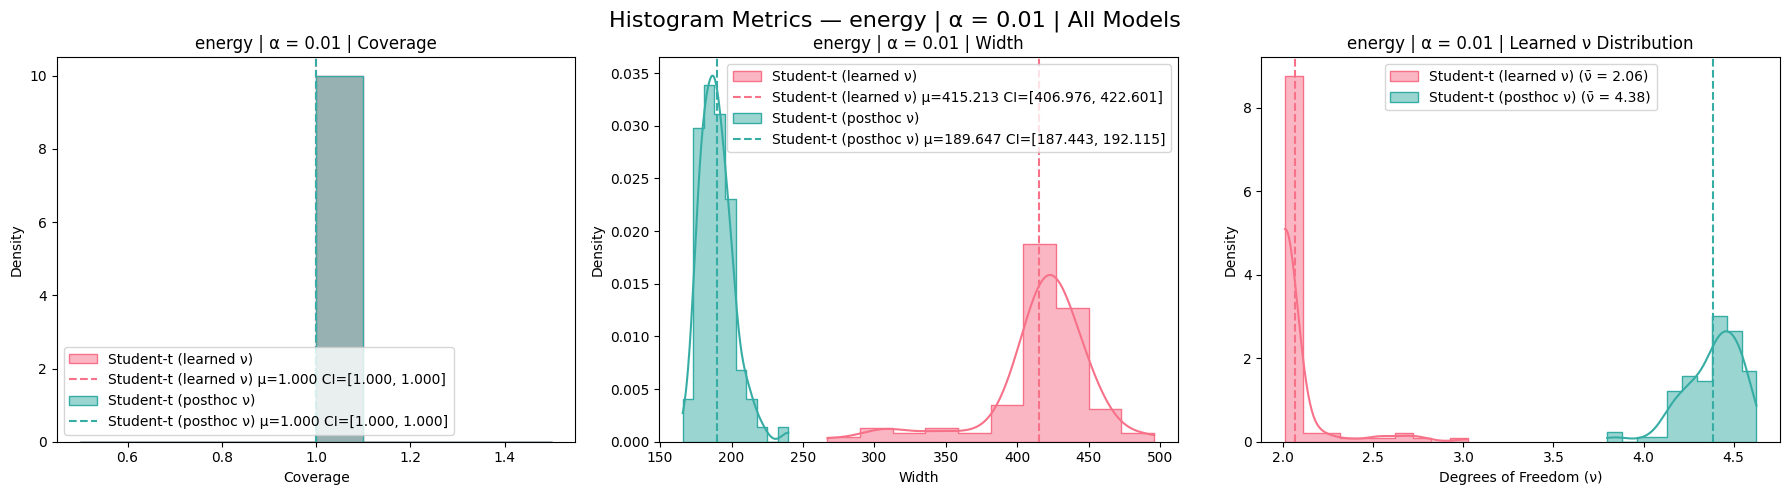


=== Dataset: energy | α = 0.05 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=4.392, σ=0.175, N=100
  studentT(unscaled)  : μ=2.099, σ=0.268, N=100

=== Percent Change Summary: energy | α = 0.05 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 1.0000 → 0.9903 (-0.97%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 181.5960 → 117.8585 (-35.10%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = 7.847, p_t = 5.1e-12 | W = 0.000, p_w = 8.43e-11

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 37.367, p_t = 3.57e-60 | W = 0.000, p_w = 3.9e-18


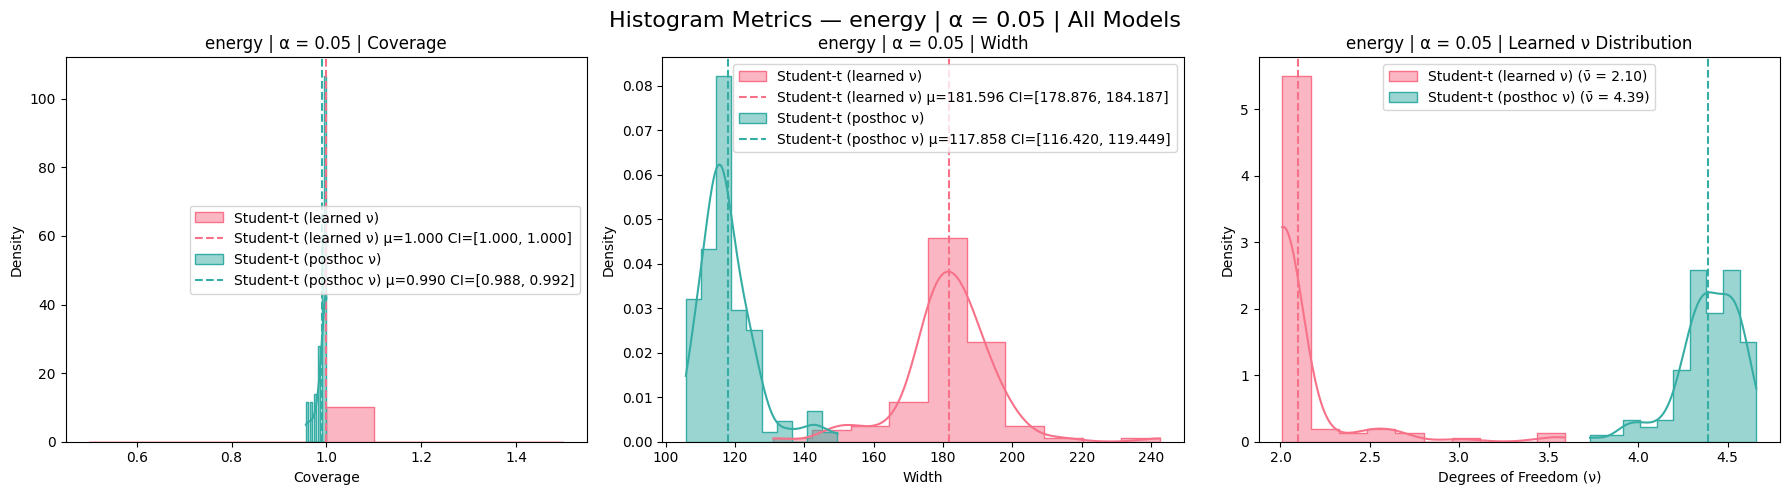


=== Dataset: energy | α = 0.1 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=4.407, σ=0.163, N=100
  studentT(unscaled)  : μ=2.106, σ=0.286, N=100

=== Percent Change Summary: energy | α = 0.1 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9946 → 0.9611 (-3.36%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 125.3800 → 90.6503 (-27.70%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = 19.894, p_t = 2.29e-36 | W = 13.000, p_w = 1.38e-17

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 33.367, p_t = 1.16e-55 | W = 0.000, p_w = 3.9e-18


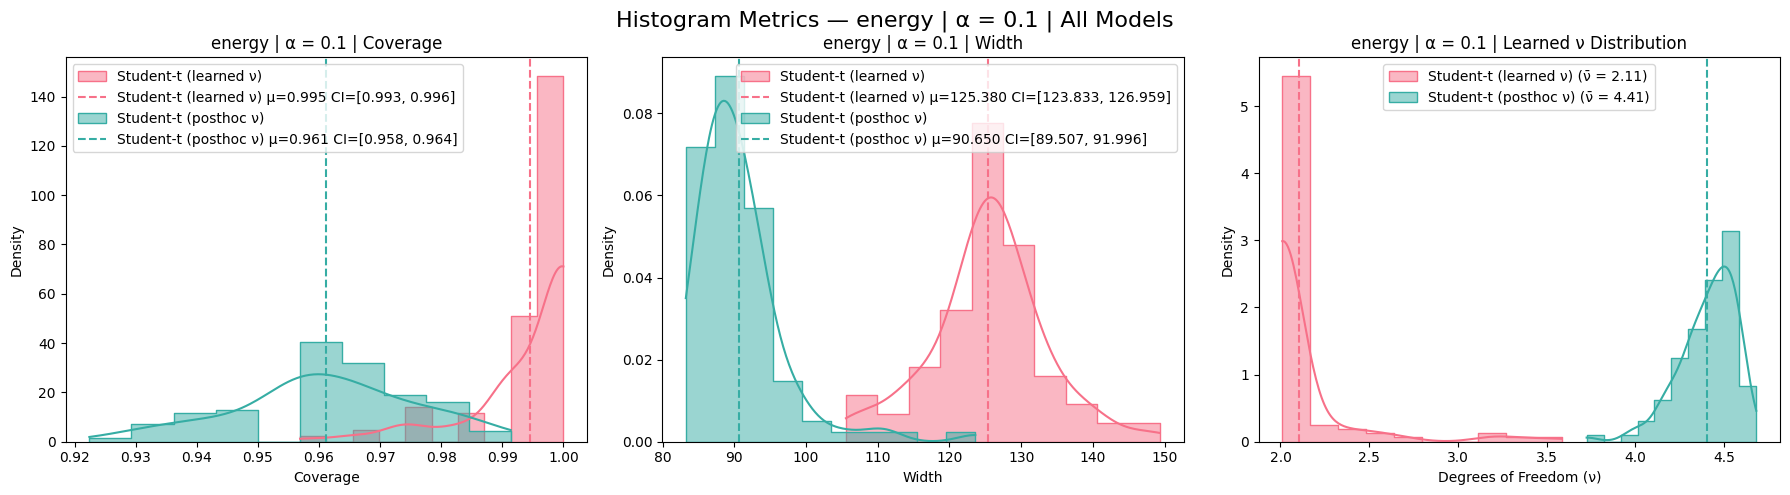


=== Dataset: ishigami_1d | α = 0.01 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=3.793, σ=0.556, N=100
  studentT(unscaled)  : μ=18.814, σ=26.419, N=100

=== Percent Change Summary: ishigami_1d | α = 0.01 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9994 → 1.0000 (+0.06%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 41.8932 → 27.2175 (-35.03%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = -5.779, p_t = 8.73e-08 | W = 0.000, p_w = 2.56e-06

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 9.388, p_t = 2.37e-15 | W = 435.000, p_w = 6.67e-13


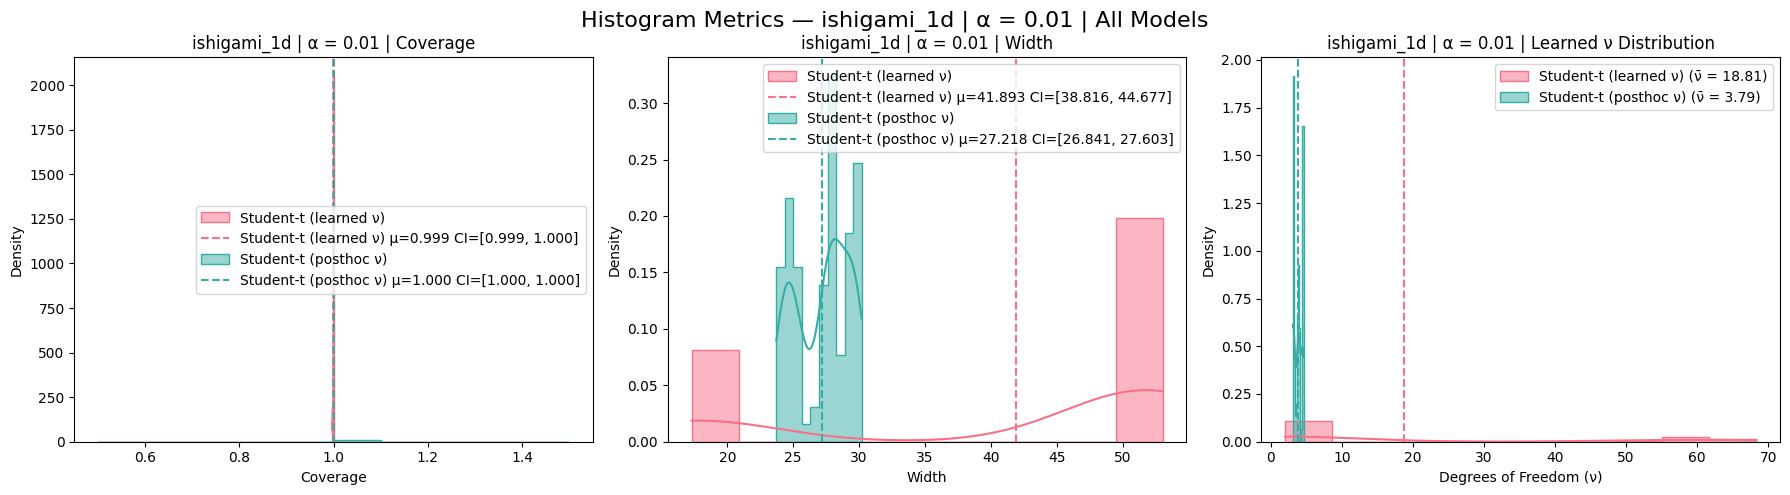


=== Dataset: ishigami_1d | α = 0.05 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=3.853, σ=0.581, N=100
  studentT(unscaled)  : μ=19.032, σ=26.245, N=100

=== Percent Change Summary: ishigami_1d | α = 0.05 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9898 → 0.9929 (+0.32%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 19.7497 → 16.1904 (-18.02%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = -1.852, p_t = 0.067 | W = 2514.000, p_w = 0.97

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 7.925, p_t = 3.47e-12 | W = 465.000, p_w = 1.41e-12


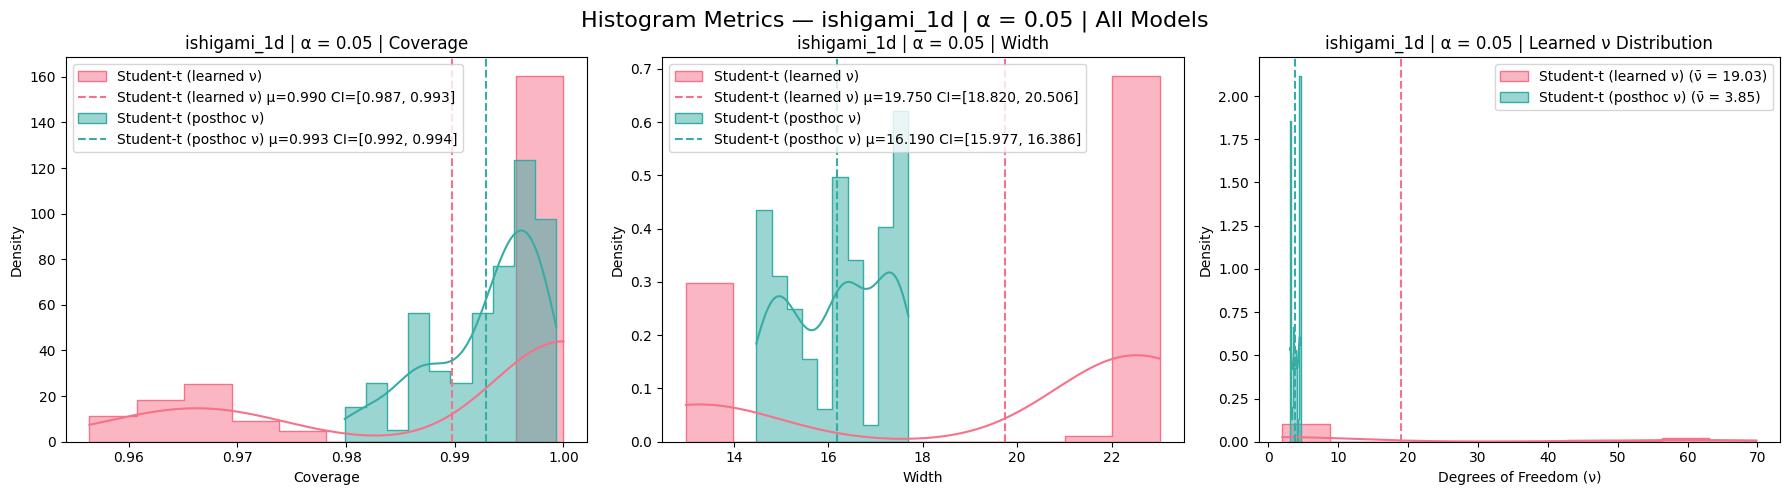


=== Dataset: ishigami_1d | α = 0.1 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=3.802, σ=0.574, N=100
  studentT(unscaled)  : μ=23.235, σ=28.435, N=100

=== Percent Change Summary: ishigami_1d | α = 0.1 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9607 → 0.9404 (-2.12%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 13.7682 → 12.2363 (-11.13%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = 4.702, p_t = 8.36e-06 | W = 1314.000, p_w = 3.13e-05

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 7.064, p_t = 2.27e-10 | W = 826.000, p_w = 5.17e-09


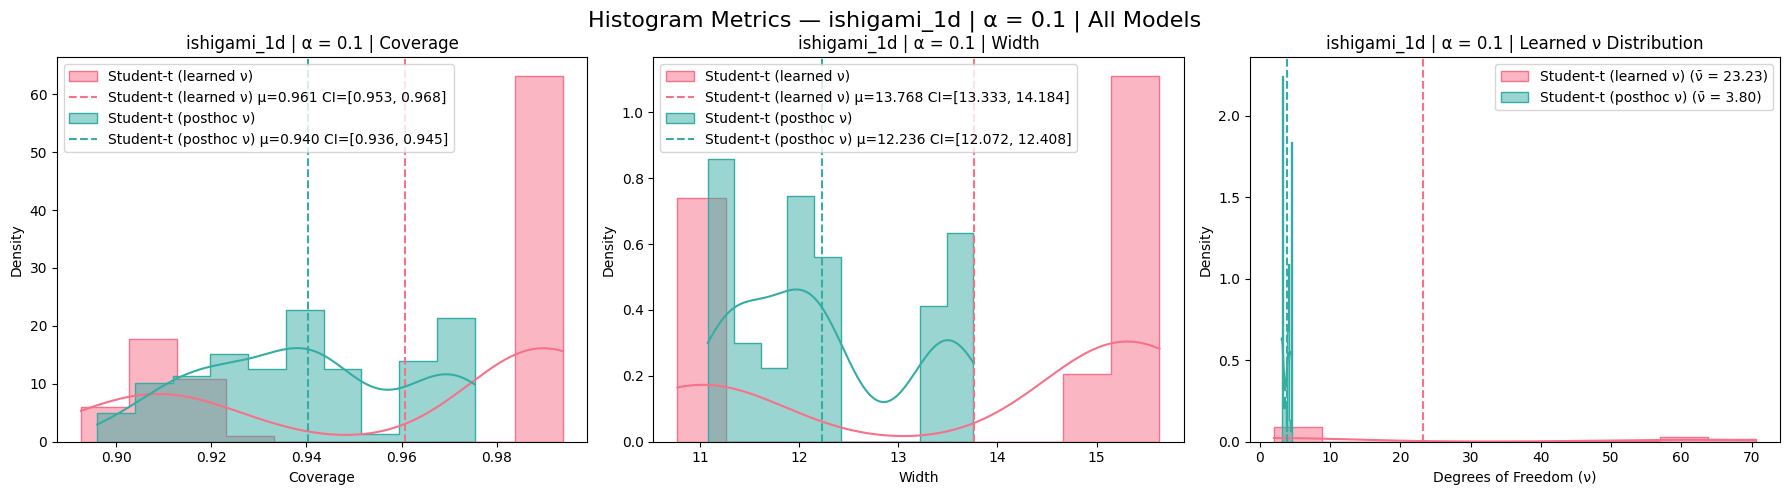


=== Dataset: ishigami_3d | α = 0.01 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=3.655, σ=0.455, N=100
  studentT(unscaled)  : μ=8.174, σ=5.185, N=100

=== Percent Change Summary: ishigami_3d | α = 0.01 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9945 → 0.9995 (+0.51%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 38.5259 → 35.2231 (-8.57%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = -10.409, p_t = 1.4e-17 | W = 741.000, p_w = 1.43e-09

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 1.965, p_t = 0.0522 | W = 1890.000, p_w = 0.029


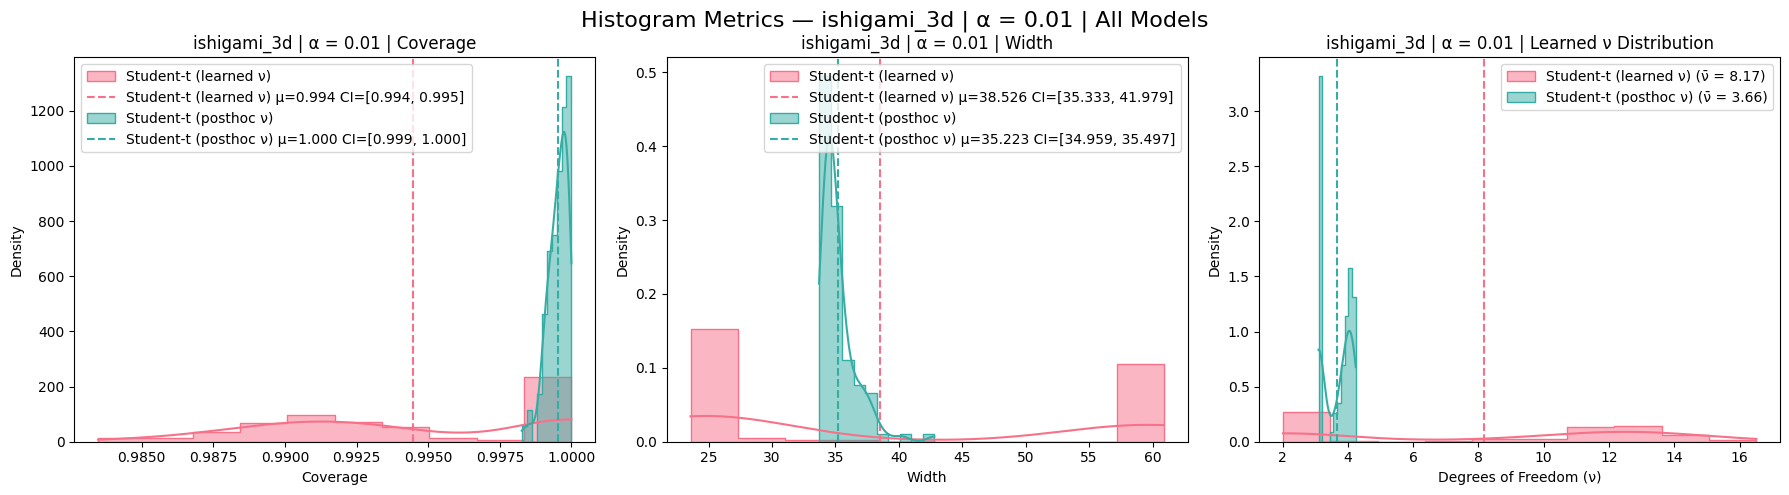


=== Dataset: ishigami_3d | α = 0.05 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=3.579, σ=0.475, N=100
  studentT(unscaled)  : μ=8.722, σ=5.305, N=100

=== Percent Change Summary: ishigami_3d | α = 0.05 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9658 → 0.9725 (+0.70%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 20.4267 → 20.4108 (-0.08%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = -3.092, p_t = 0.00259 | W = 1704.000, p_w = 0.00476

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 0.036, p_t = 0.971 | W = 2273.000, p_w = 0.386


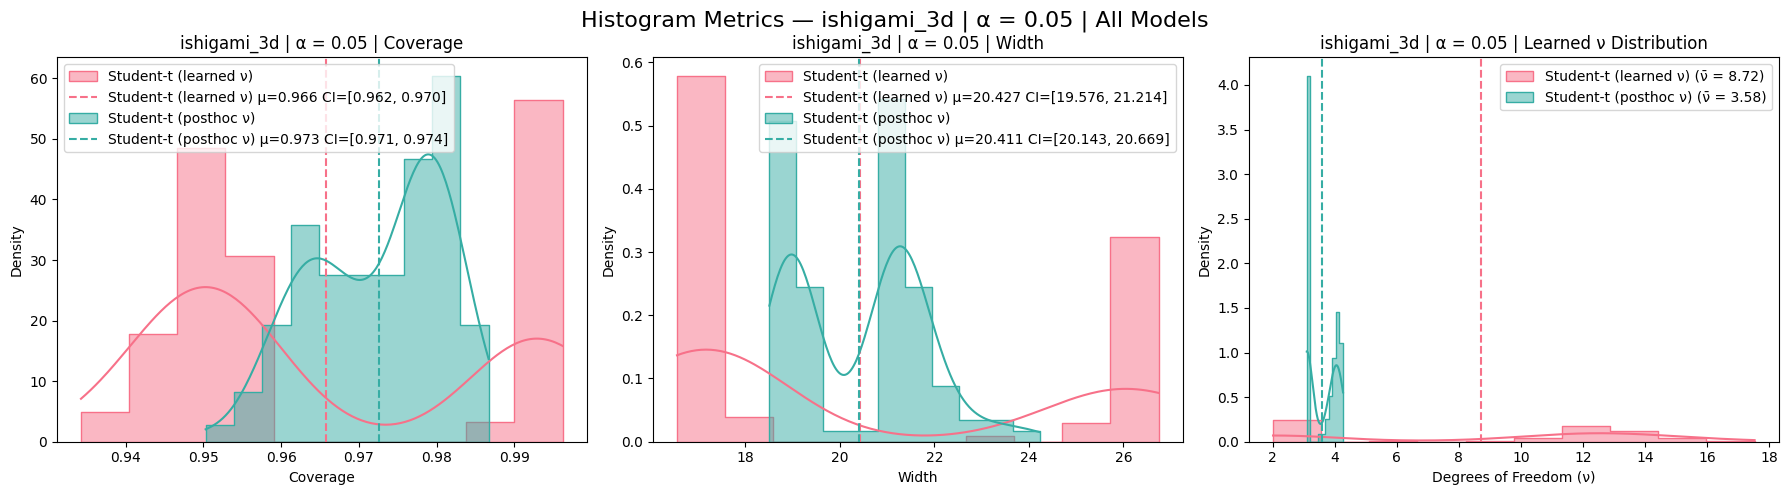


=== Dataset: ishigami_3d | α = 0.1 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=3.581, σ=0.472, N=100
  studentT(unscaled)  : μ=7.913, σ=5.376, N=100

=== Percent Change Summary: ishigami_3d | α = 0.1 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9247 → 0.9249 (+0.02%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 15.5769 → 15.5175 (-0.38%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = -0.055, p_t = 0.956 | W = 2499.000, p_w = 0.929

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 0.266, p_t = 0.791 | W = 2517.000, p_w = 0.978


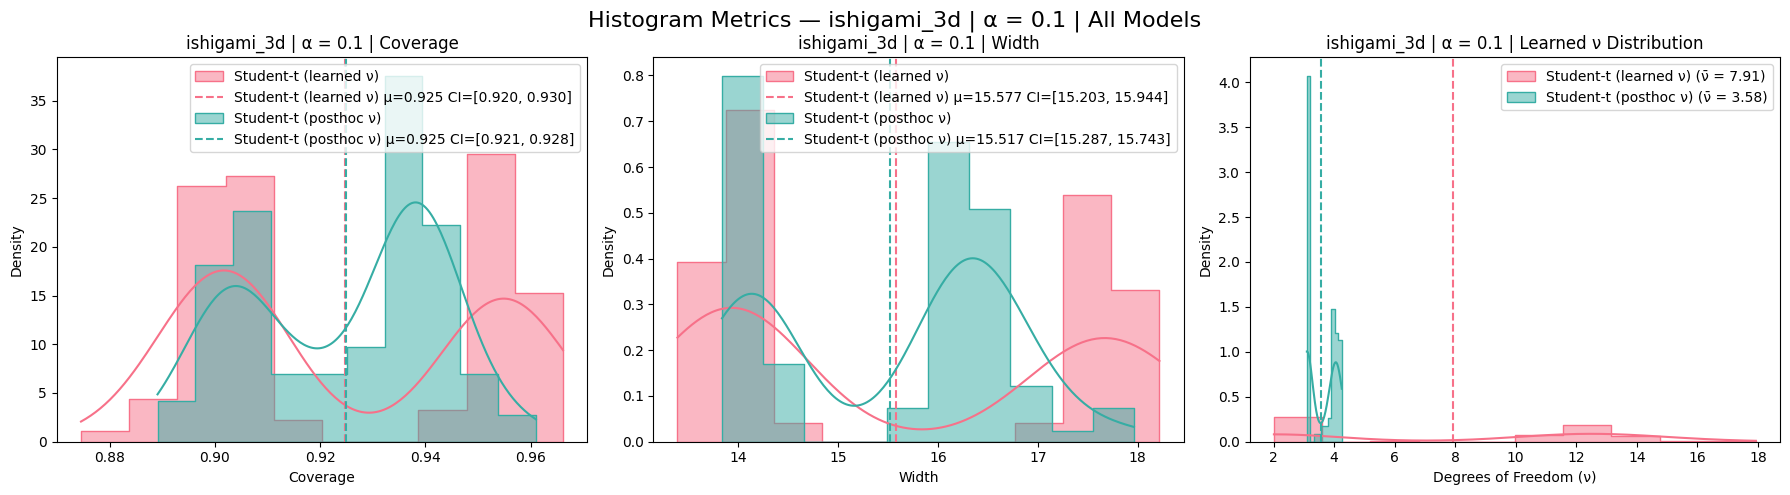


=== Dataset: sinusoidal | α = 0.01 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=4.508, σ=0.120, N=100
  studentT(unscaled)  : μ=25.838, σ=34.916, N=100

=== Percent Change Summary: sinusoidal | α = 0.01 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 1.0000 → 1.0000 (+0.00%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 19.5220 → 11.4183 (-41.51%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = -1.495, p_t = 0.138 | W = 0.000, p_w = 0.109

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 10.117, p_t = 6.08e-17 | W = 528.000, p_w = 6.59e-12


C:\Users\MKnod\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


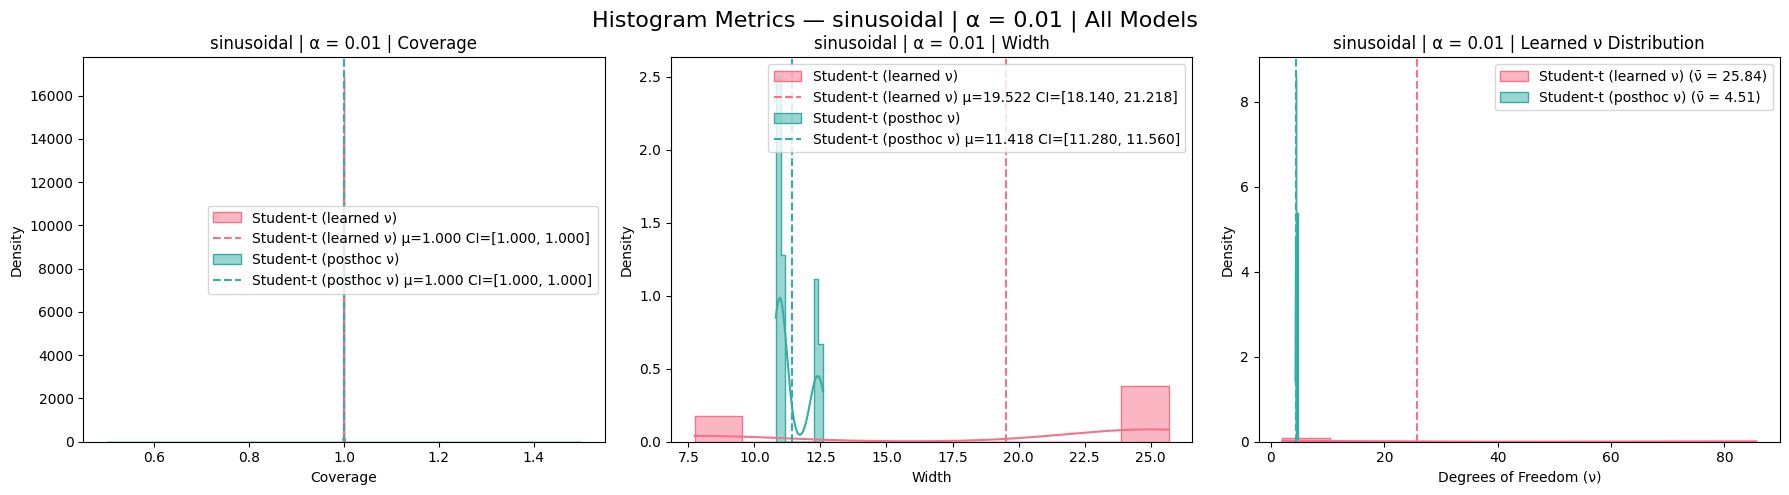


=== Dataset: sinusoidal | α = 0.05 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=4.484, σ=0.110, N=100
  studentT(unscaled)  : μ=29.282, σ=37.211, N=100

=== Percent Change Summary: sinusoidal | α = 0.05 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9973 → 0.9993 (+0.20%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 9.1418 → 7.0196 (-23.21%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = -4.959, p_t = 2.94e-06 | W = 1085.000, p_w = 0.00674

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 8.744, p_t = 5.95e-14 | W = 630.000, p_w = 7.24e-11


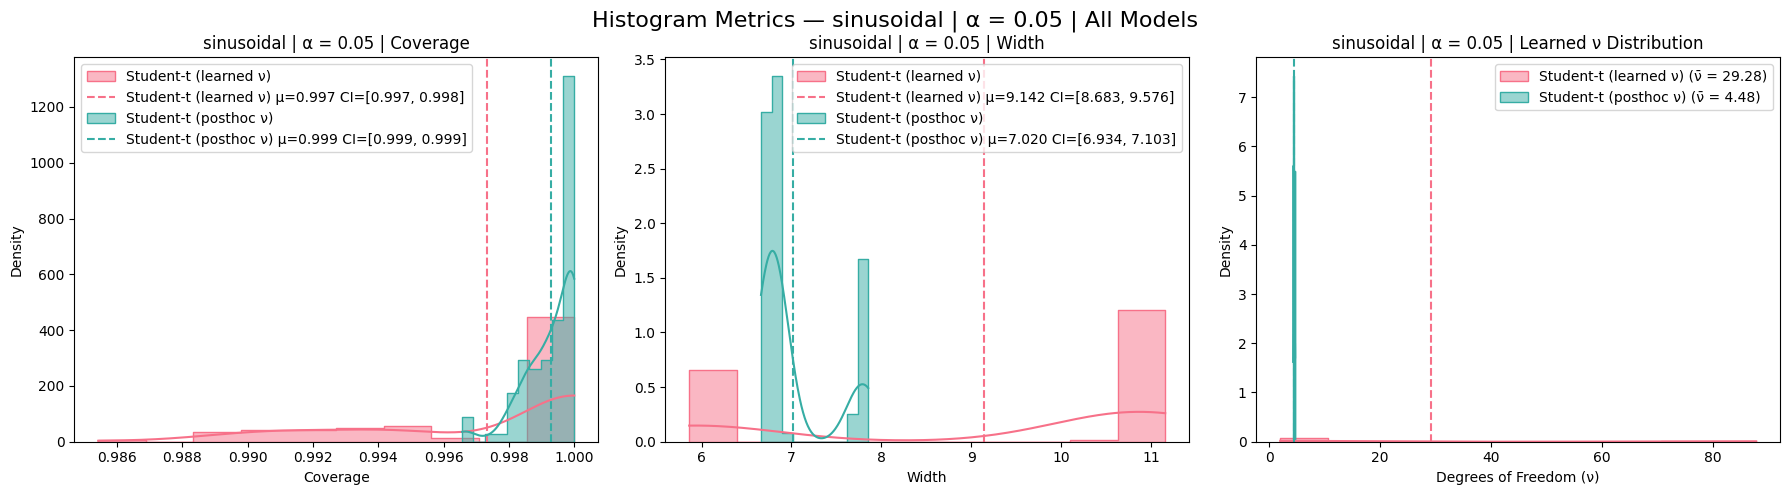


=== Dataset: sinusoidal | α = 0.1 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=4.527, σ=0.129, N=100
  studentT(unscaled)  : μ=27.063, σ=35.760, N=100

=== Percent Change Summary: sinusoidal | α = 0.1 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9819 → 0.9776 (-0.44%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 6.5830 → 5.5917 (-15.06%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = 1.507, p_t = 0.135 | W = 1933.000, p_w = 0.0418

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 8.392, p_t = 3.44e-13 | W = 561.000, p_w = 1.45e-11


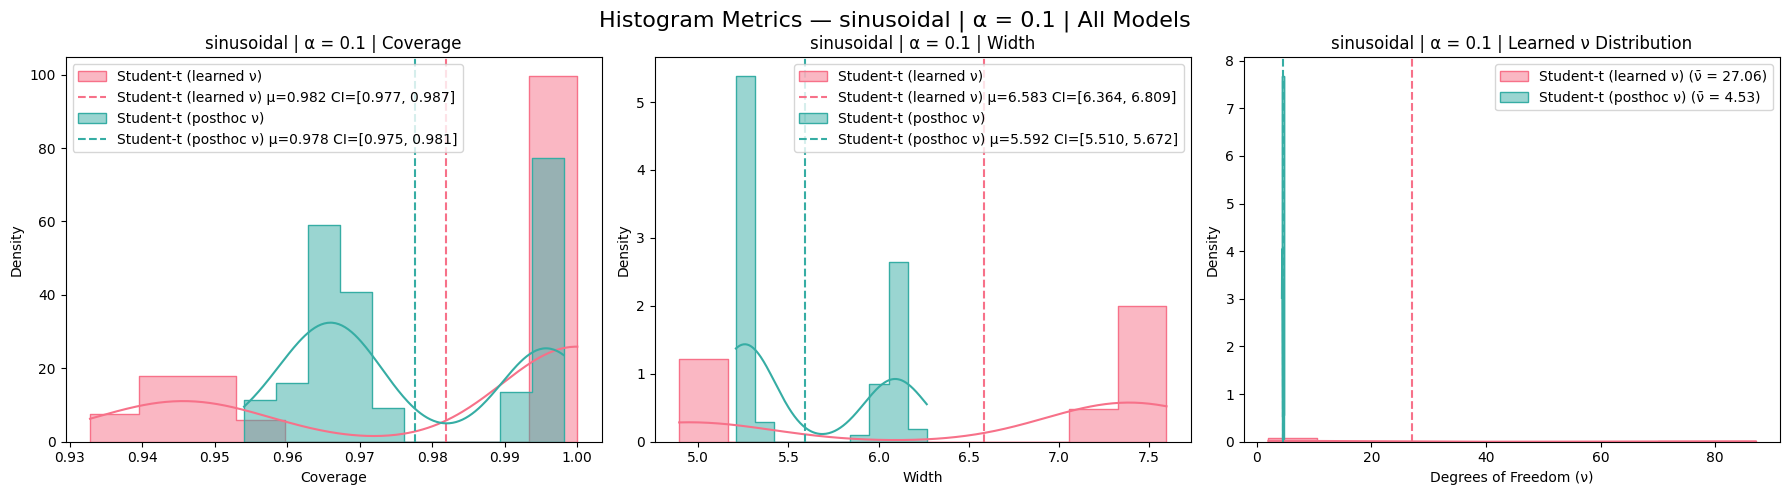


=== Dataset: wine-red | α = 0.01 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=4.072, σ=0.458, N=100
  studentT(unscaled)  : μ=2.162, σ=0.514, N=100

=== Percent Change Summary: wine-red | α = 0.01 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 1.0000 → 0.9990 (-0.09%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 17.4932 → 8.6074 (-50.80%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = 4.549, p_t = 1.53e-05 | W = 10.500, p_w = 3.37e-05

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 23.314, p_t = 5.39e-42 | W = 4.000, p_w = 4.4e-18


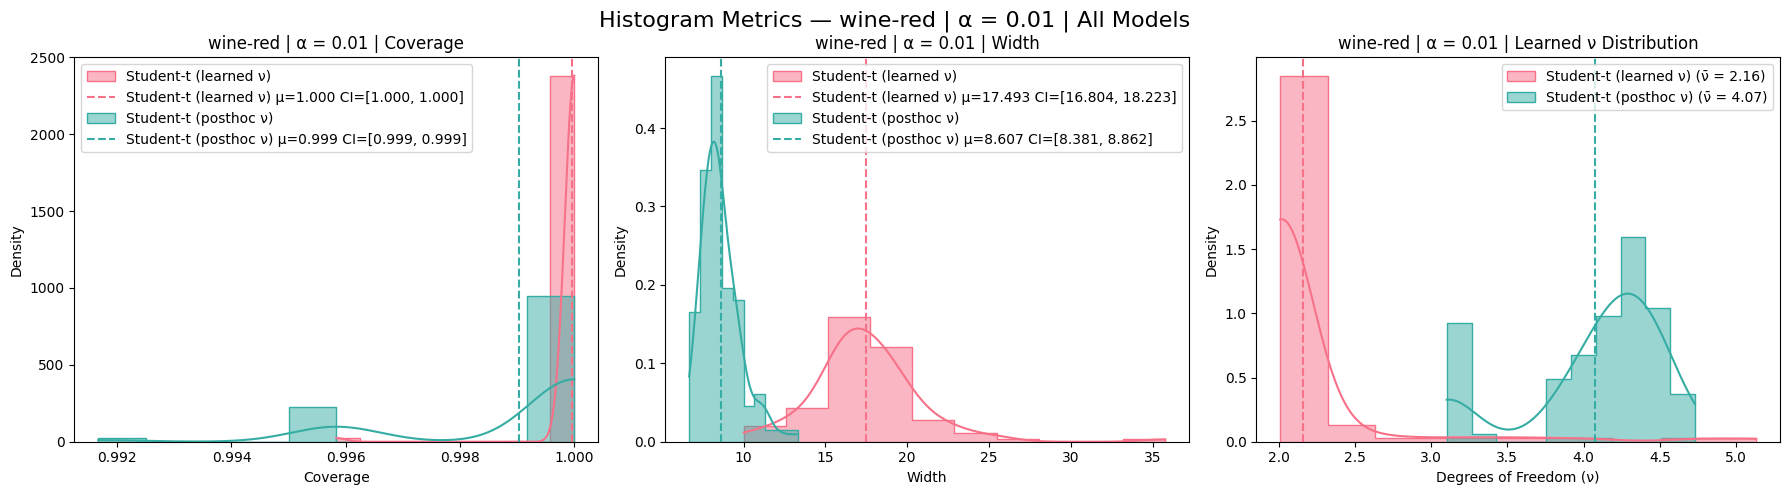


=== Dataset: wine-red | α = 0.05 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=4.152, σ=0.368, N=100
  studentT(unscaled)  : μ=2.157, σ=0.465, N=100

=== Percent Change Summary: wine-red | α = 0.05 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9967 → 0.9823 (-1.45%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 7.5364 → 5.1264 (-31.98%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = 16.586, p_t = 2.45e-30 | W = 70.000, p_w = 9.63e-17

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 15.935, p_t = 4.44e-29 | W = 63.000, p_w = 2.56e-17


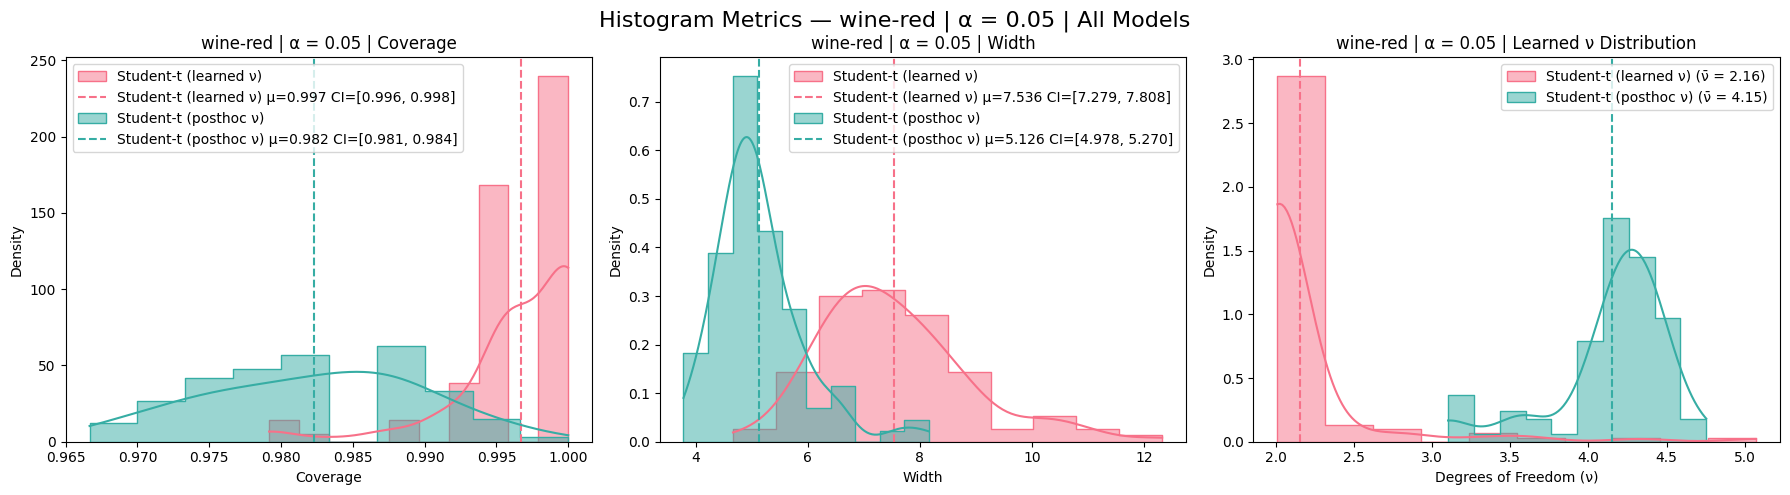


=== Dataset: wine-red | α = 0.1 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=4.109, σ=0.414, N=100
  studentT(unscaled)  : μ=2.280, σ=0.905, N=100

=== Percent Change Summary: wine-red | α = 0.1 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9816 → 0.9537 (-2.84%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 5.2901 → 3.9430 (-25.46%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = 16.227, p_t = 1.2e-29 | W = 72.000, p_w = 4.9e-17

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 12.227, p_t = 1.68e-21 | W = 203.000, p_w = 1.42e-15


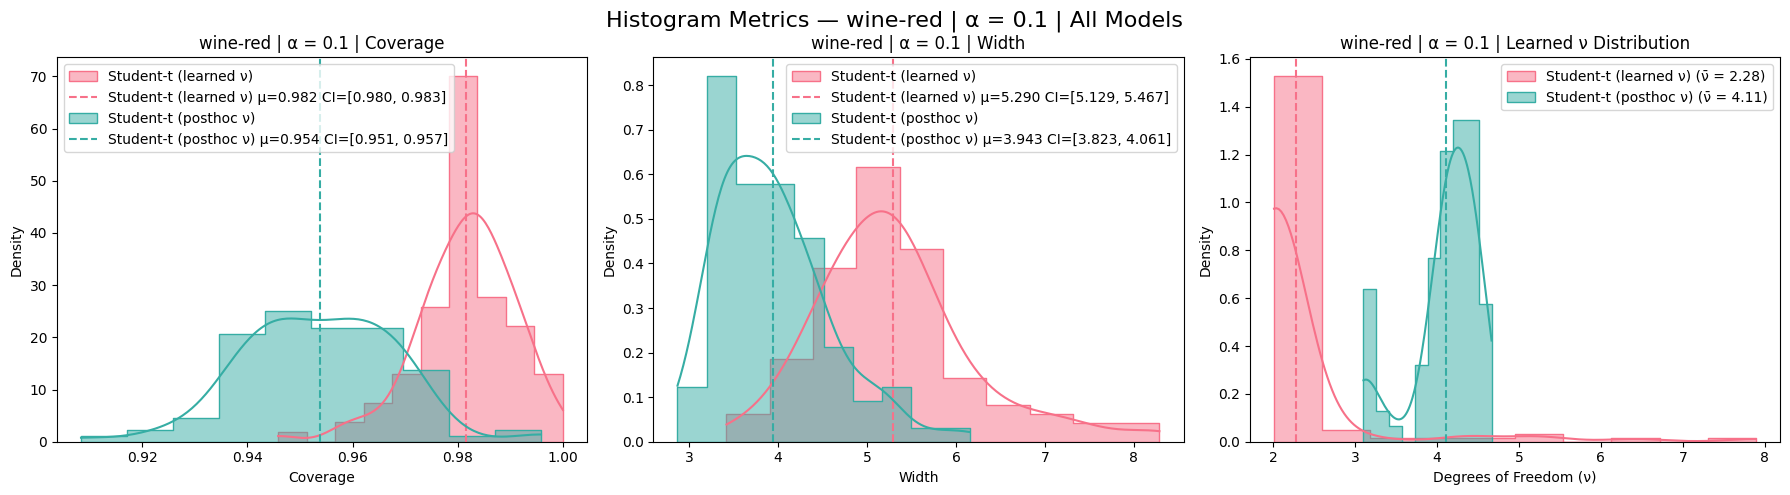


=== Dataset: wine-white | α = 0.01 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=3.152, σ=0.194, N=100
  studentT(unscaled)  : μ=3.253, σ=2.726, N=100

=== Percent Change Summary: wine-white | α = 0.01 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9975 → 0.9975 (-0.00%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 9.0403 → 6.0487 (-33.09%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = 0.158, p_t = 0.875 | W = 1183.000, p_w = 0.347

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 13.415, p_t = 5.3e-24 | W = 188.000, p_w = 9.33e-16


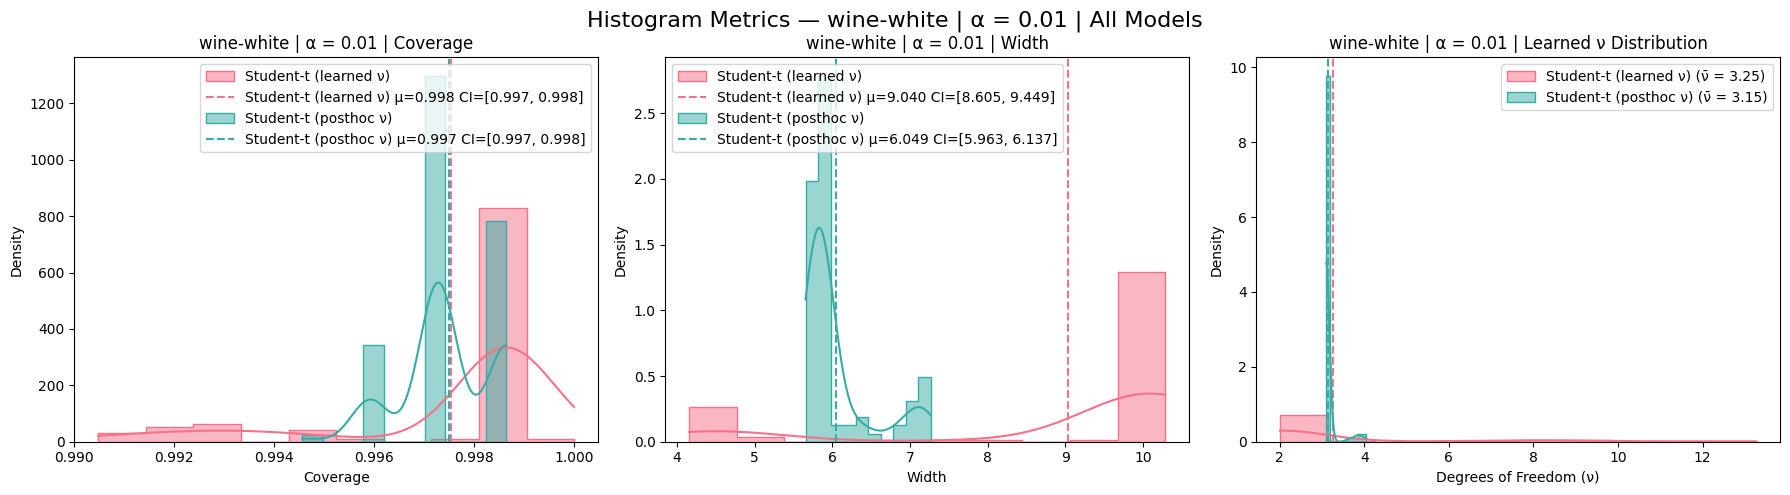


=== Dataset: wine-white | α = 0.05 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=3.121, σ=0.123, N=100
  studentT(unscaled)  : μ=3.472, σ=2.844, N=100

=== Percent Change Summary: wine-white | α = 0.05 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9869 → 0.9727 (-1.43%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 4.0847 → 3.3046 (-19.10%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = 10.498, p_t = 9e-18 | W = 394.500, p_w = 6.1e-13

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 12.995, p_t = 3.99e-23 | W = 309.000, p_w = 2.55e-14


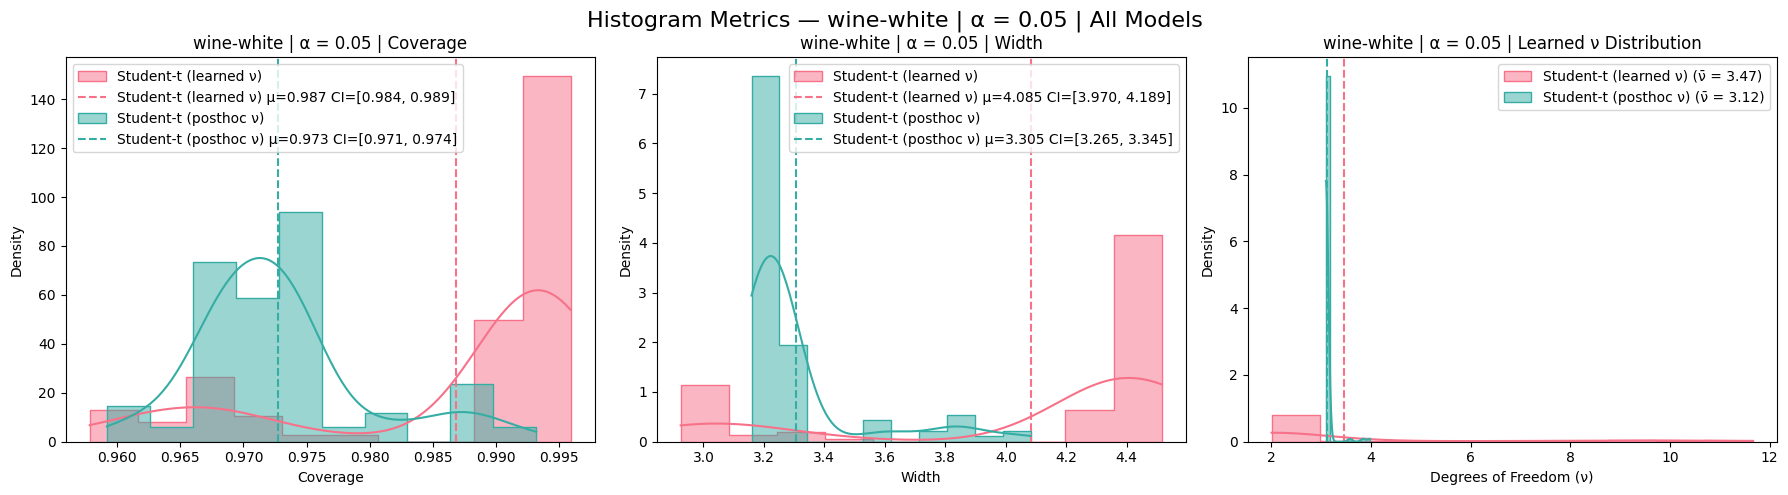


=== Dataset: wine-white | α = 0.1 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=3.144, σ=0.154, N=100
  studentT(unscaled)  : μ=2.876, σ=2.218, N=100

=== Percent Change Summary: wine-white | α = 0.1 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9517 → 0.9198 (-3.36%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 2.9176 → 2.5270 (-13.39%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = 11.306, p_t = 1.59e-19 | W = 348.500, p_w = 1.15e-13

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 12.753, p_t = 1.29e-22 | W = 182.000, p_w = 7.88e-16


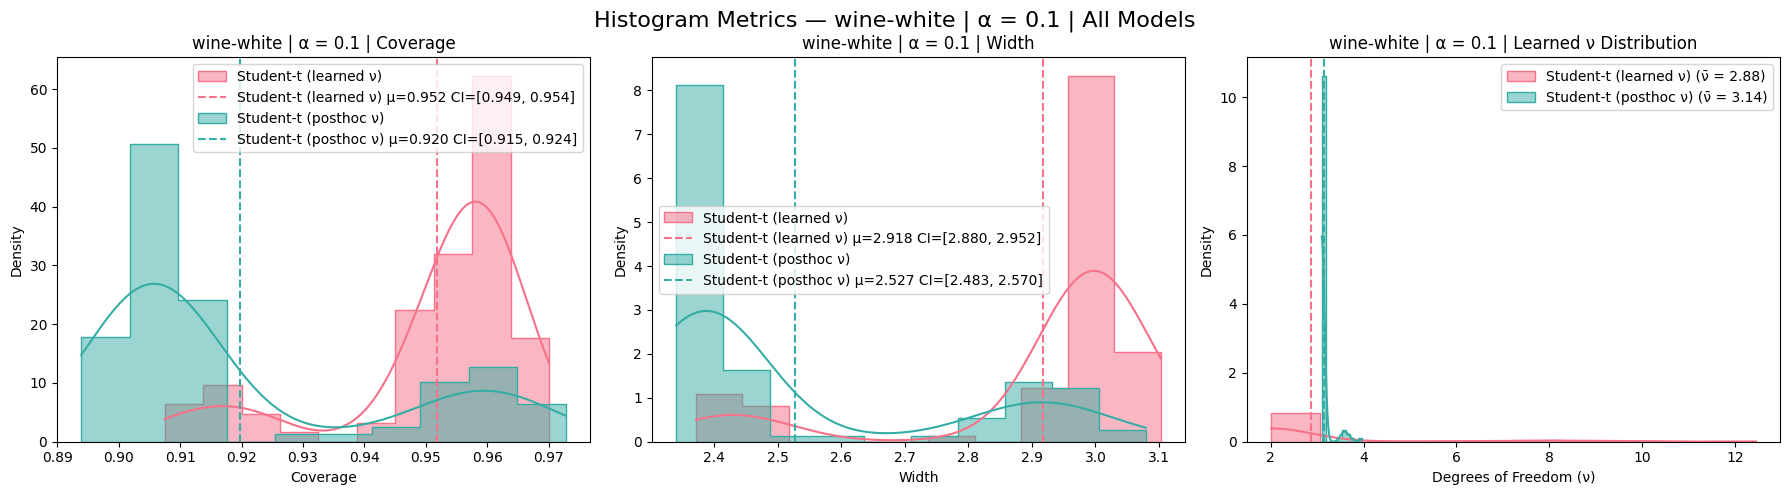


=== Dataset: yacht | α = 0.01 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=2.516, σ=0.003, N=100
  studentT(unscaled)  : μ=2.011, σ=0.006, N=100

=== Percent Change Summary: yacht | α = 0.01 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.9543 → 0.8951 (-6.20%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 38.3443 → 27.1995 (-29.07%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = 12.456, p_t = 5.49e-22 | W = 70.000, p_w = 7.71e-15

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 21.172, p_t = 1.54e-38 | W = 4.000, p_w = 4.4e-18


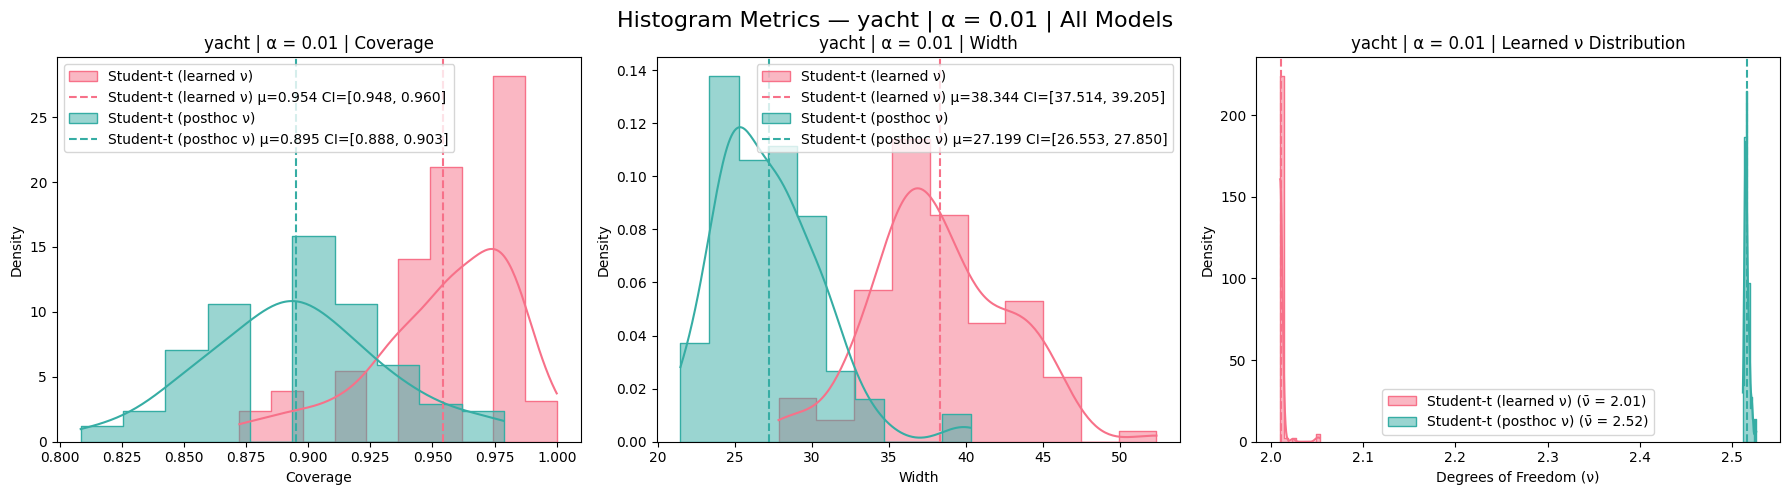


=== Dataset: yacht | α = 0.05 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=2.516, σ=0.003, N=100
  studentT(unscaled)  : μ=2.011, σ=0.008, N=100

=== Percent Change Summary: yacht | α = 0.05 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.8145 → 0.7894 (-3.08%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 16.5421 → 13.7775 (-16.71%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = 5.807, p_t = 7.7e-08 | W = 654.000, p_w = 4.07e-07

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 11.533, p_t = 5.14e-20 | W = 281.000, p_w = 1.2e-14


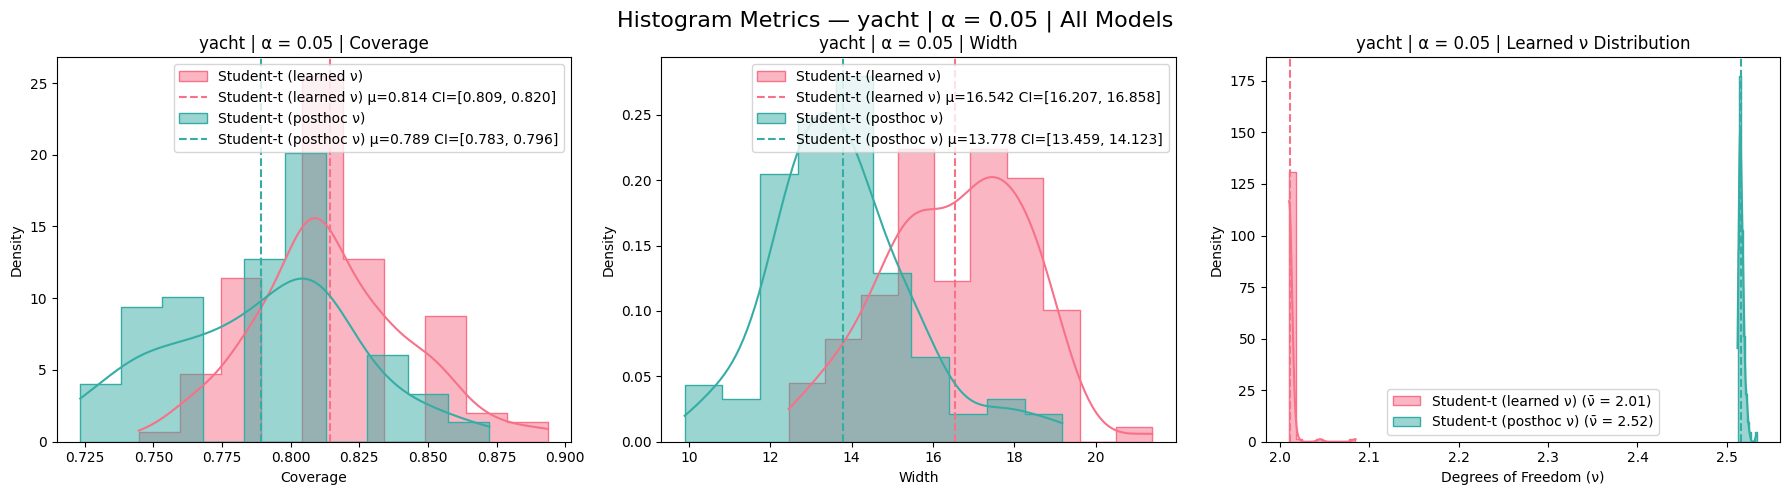


=== Dataset: yacht | α = 0.1 | Trials: 200 ===
ν Summary:
  studentT(posthoc_nu): μ=2.517, σ=0.004, N=100
  studentT(unscaled)  : μ=2.011, σ=0.005, N=100

=== Percent Change Summary: yacht | α = 0.1 ===

--- Coverage ---
studentT(unscaled)   → studentT(posthoc_nu): 0.7564 → 0.7306 (-3.40%)

--- Width ---
studentT(unscaled)   → studentT(posthoc_nu): 11.1948 → 9.9450 (-11.16%)

--- Coverage ---
  studentT(unscaled) → studentT(posthoc_nu): t = 4.825, p_t = 5.08e-06 | W = 1062.500, p_w = 2.66e-05

--- Width ---
  studentT(unscaled) → studentT(posthoc_nu): t = 6.918, p_t = 4.57e-10 | W = 806.000, p_w = 3.41e-09


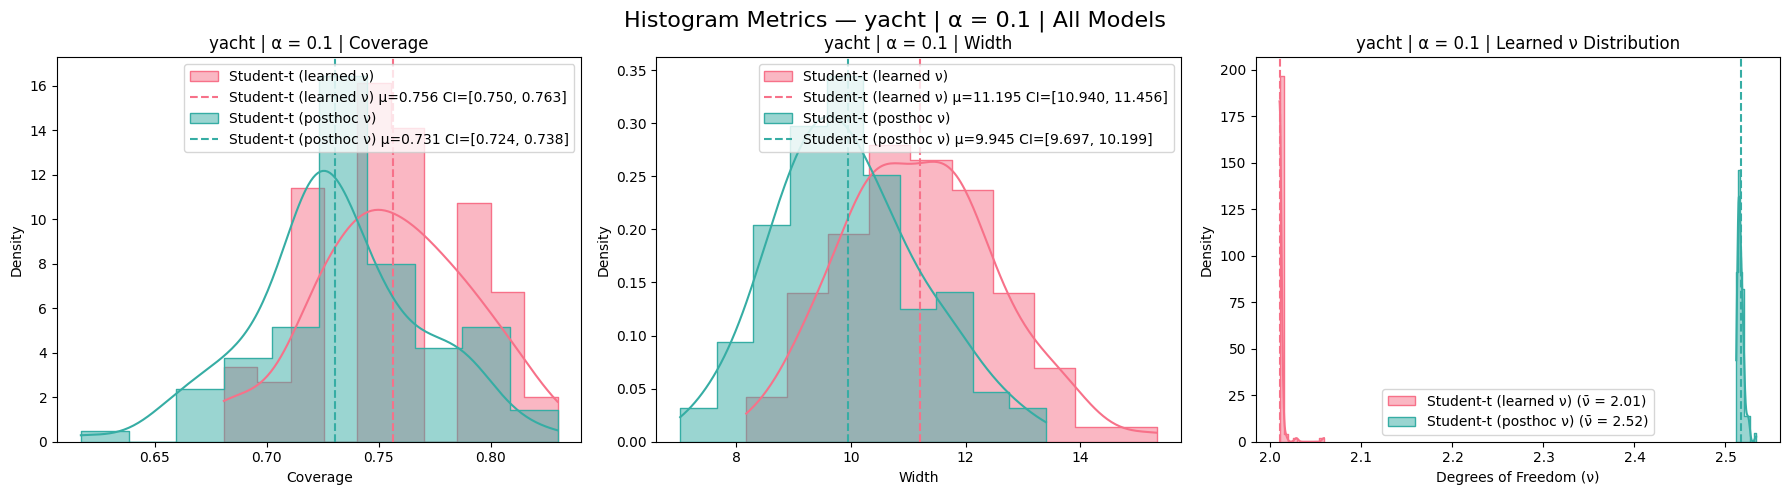

In [5]:
# Load saved CSV
csv_file = "reg_temp_experiment_cp_tdist_TEST.csv"
PLOT_DIR = "reg_temp_experiment_cp_tdist_TEST_PLOTS"
df = pd.read_csv(csv_file)

# Identify all dataset-alpha pairs
dataset_alpha_pairs = df.groupby(["Dataset", "Alpha"]).size().index.tolist()

for dataset, alpha_ in dataset_alpha_pairs:
    # === Filter subset for current dataset/α pair ===
    subset = df[(df["Dataset"] == dataset) & (df["Alpha"] == alpha_)]

    print(f"\n=== Dataset: {dataset} | α = {alpha_} | Trials: {len(subset)} ===")

    # Reinitialize per-dataset containers
    coverages = defaultdict(list)
    widths = defaultdict(list)
    maes = defaultdict(list)
    miscoverages = defaultdict(list)
    calib_errors = defaultdict(list)
    losses = defaultdict(list)
    nu_dict = defaultdict(list)

    # === Fill containers from CSV ===
    for _, row in subset.iterrows():
        strategy = row["Strategy"]

        coverages[strategy].append(row["Coverage"])
        widths[strategy].append(row["Width"])
        maes[strategy].append(row["MAE"])
        miscoverages[strategy].append(row["Miscoverage"])
        calib_errors[strategy].append(row["CalibrationError"])
        losses[strategy].append(row["Loss"])

        mean_nu = row.get("MeanNu", np.nan)
        if not pd.isna(mean_nu):
            nu_dict[strategy].append(mean_nu)

    # Convert ν to arrays
    for strat in nu_dict:
        nu_dict[strat] = np.array(nu_dict[strat])

    # === Diagnostic: print ν summary ===
    print(f"ν Summary:")
    for strat in sorted(nu_dict.keys()):
        vals = nu_dict[strat]
        print(f"  {strat:20}: μ={np.mean(vals):.3f}, σ={np.std(vals):.3f}, N={len(vals)}")

    # === Construct metric dictionary ===
    metric_data_dict = {
        "Coverage": {
            "studentT(unscaled)": coverages["studentT(unscaled)"],
            "studentT(posthoc_nu)": coverages["studentT(posthoc_nu)"]
        },
        "Width": {
            "studentT(unscaled)": widths["studentT(unscaled)"],
            "studentT(posthoc_nu)": widths["studentT(posthoc_nu)"]
        },
        "MAE": {
            "studentT(unscaled)": maes["studentT(unscaled)"],
            "studentT(posthoc_nu)": maes["studentT(posthoc_nu)"]
        },
        "Miscoverage": {
            "studentT(unscaled)": miscoverages["studentT(unscaled)"],
            "studentT(posthoc_nu)": miscoverages["studentT(posthoc_nu)"]
        },
        "Calibration Error": {
            "studentT(unscaled)": calib_errors["studentT(unscaled)"],
            "studentT(posthoc_nu)": calib_errors["studentT(posthoc_nu)"]
        },
        "Student-t NLL Loss": {
            "studentT(unscaled)": losses["studentT(unscaled)"],
            "studentT(posthoc_nu)": losses["studentT(posthoc_nu)"]
        }
    }
    
    metric_data_dict = {
        "Coverage": {
            "studentT(unscaled)": coverages["studentT(unscaled)"],
            "studentT(posthoc_nu)": coverages["studentT(posthoc_nu)"]
        },
        "Width": {
            "studentT(unscaled)": widths["studentT(unscaled)"],
            "studentT(posthoc_nu)": widths["studentT(posthoc_nu)"]
        }
    }

    # === Output summaries ===
    print_all_percent_change_summaries(metric_data_dict, label=f"{dataset} | α = {alpha_}")

    # === Close any stale plots ===
    plt.close("all")

    # === Call updated histogram plotter ===
    plot_with_seaborn_all_strategies(
        metric_data_dict=metric_data_dict,
        title_prefix=f"{dataset} | α = {alpha_}",
        ylabel="Density",
        name="All Models",
        alpha_=alpha_,
        data=dataset,
        nu_dict=nu_dict,
        output_dir=PLOT_DIR
    )


font increase, legend adjustments, reason for why larger learned nu through post-hoc calibration results in smaller width, 
plot t distribution with given nu and sigma, multiply by facot of 2-3, see what happens to area underneath.


Switch priority to this after masters.

In [6]:
df = pd.read_csv(csv_file)

# Compute the average of each metric grouped by Dataset, Alpha, and Strategy
average_metrics = df.groupby(["Dataset", "Alpha", "Strategy"]).agg({
    "Coverage": "mean",
    "Width": "mean",
#    "MAE": "mean",
#    "Miscoverage": "mean",
#    "CalibrationError": "mean",
#    "Loss": "mean",
    "MeanNu": "mean"
}).reset_index()


# Optional: round for better readability
average_metrics = average_metrics.round(4)

# Sort by Dataset, Alpha, then Strategy for clarity
average_metrics = average_metrics.sort_values(by=["Dataset", "Alpha", "Strategy"])

# Ensure all rows and columns are printed
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

pd.set_option("display.width", 200)  # increase if necessary
pd.set_option("display.colheader_justify", "left")  # optional: align headers to left

# Display or print
print(average_metrics)


   Dataset       Alpha Strategy               Coverage  Width     MeanNu 
0        energy  0.01   studentT(posthoc_nu)  1.0000    189.6469   4.3845
1        energy  0.01     studentT(unscaled)  1.0000    415.2129   2.0635
2        energy  0.05   studentT(posthoc_nu)  0.9903    117.8585   4.3923
3        energy  0.05     studentT(unscaled)  1.0000    181.5960   2.0989
4        energy  0.10   studentT(posthoc_nu)  0.9611     90.6503   4.4068
5        energy  0.10     studentT(unscaled)  0.9946    125.3800   2.1064
6   ishigami_1d  0.01   studentT(posthoc_nu)  1.0000     27.2175   3.7928
7   ishigami_1d  0.01     studentT(unscaled)  0.9994     41.8932  18.8136
8   ishigami_1d  0.05   studentT(posthoc_nu)  0.9929     16.1904   3.8534
9   ishigami_1d  0.05     studentT(unscaled)  0.9898     19.7497  19.0321
10  ishigami_1d  0.10   studentT(posthoc_nu)  0.9404     12.2363   3.8018
11  ishigami_1d  0.10     studentT(unscaled)  0.9607     13.7682  23.2349
12  ishigami_3d  0.01   studentT(posth